## Imports

In [ ]:
# !pip install pandas
# !pip install np
# !pip install tqdm
# !pip install seaborn
# !pip install matplotlib
# !pip install sklearn
# !pip install dtwalign
!pip install -r requirements.txt

In [6]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

## Data Loading

In [7]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath)
    return dataframe

def read_activity_file(data_dir, class_name, file_path: str):
    path = f'./{data_dir}/{class_name}/{file_path}'
    df = load_file(path)
    df['activity'] = class_name
    df['timestamp'] = range(30)
    return df

def read_activity_file(data_dir, class_name, file_name: str):
        
    path = f'./{data_dir}/{class_name}/{file_name}'
    df = load_file(path)
    
    df = df.rename(columns={'accelerometer_X':'x',
                  'accelerometer_Y':'y',
                  'accelerometer_Z':'z'})
    return df[['x', 'y', 'z']].values

In [8]:
data_dir = 'data'

X = []
y = []
for class_name in os.listdir(data_dir):
    if class_name=='.DS_Store':
        continue
    
    class_dir_path = f'./{data_dir}/{class_name}'
    
    for file_name in tqdm(os.listdir(class_dir_path)):
        if file_name[-3:]!='csv':
            continue
            
        sample = read_activity_file(data_dir, class_name, file_name)
        X.append(sample)
        y.append(class_name)
            
X = np.array(X)
y = np.array(y)

100%|██████████| 166/166 [00:00<00:00, 482.19it/s]


In [9]:
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (6462, 30, 3)
y shape: (6462,)


### PCA Data Visualization

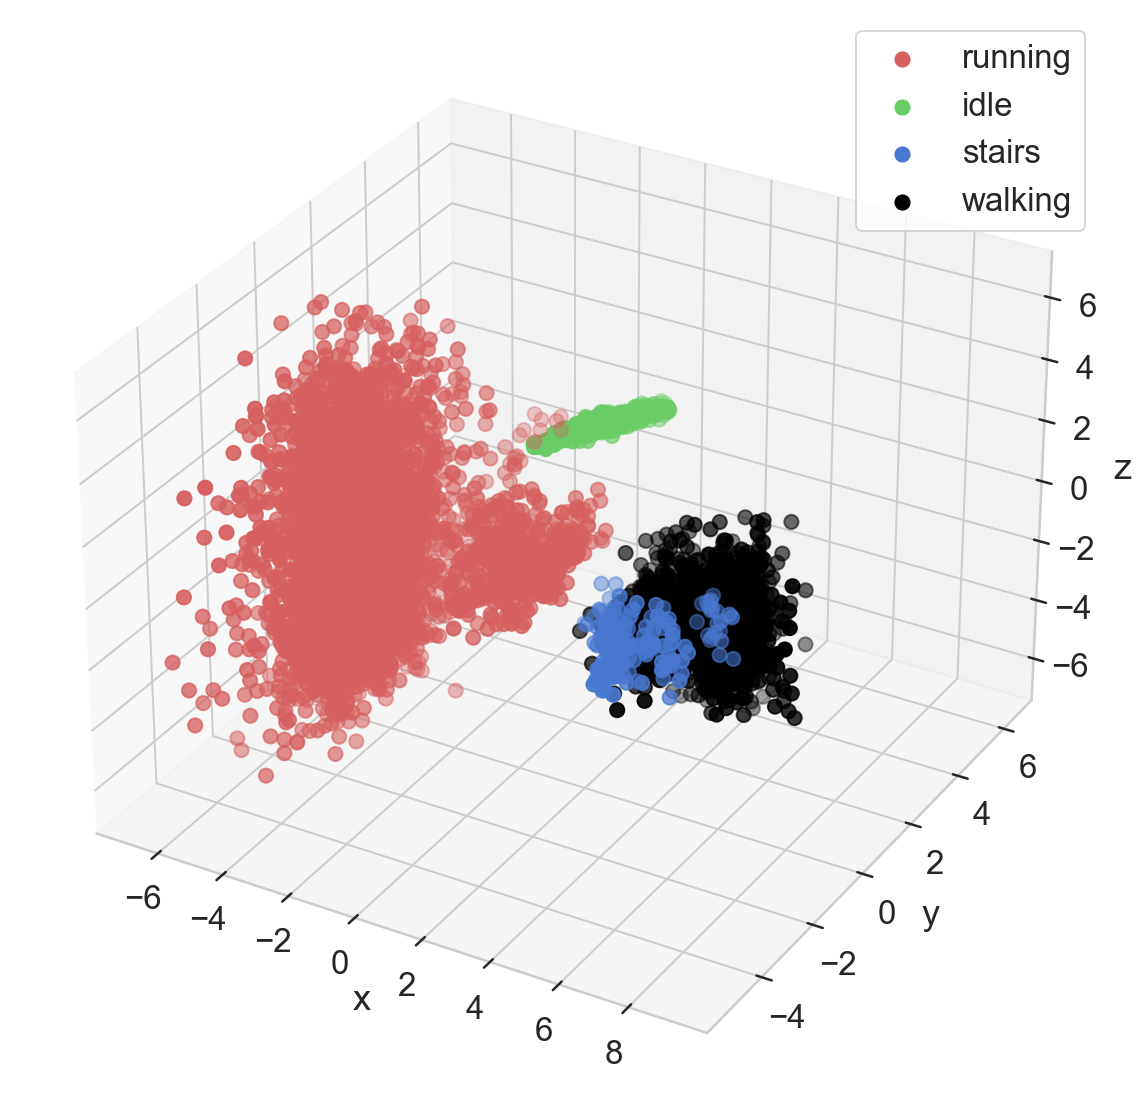

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


X_reshaped = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))
X_reshaped_scaled = StandardScaler().fit_transform(X_reshaped)


pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X_reshaped_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['x', 'y', 'z'])

principalDf['target'] = y

fig = plt.figure(figsize=(10, 10))
# Create 3D container
ax = plt.axes(projection = '3d')
# Visualize 3D scatter plot

targets = ['running', 'idle', 'stairs', 'walking']
colors = ['r', 'g', 'b', 'black']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter3D(principalDf.loc[indicesToKeep, 'x'], 
                 principalDf.loc[indicesToKeep, 'y'], 
                 principalDf.loc[indicesToKeep, 'z'], c = color, s = 50)

ax.legend(targets)

# Give labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# Save figure
plt.savefig('3d_scatter.png', dpi = 300);

### Train/test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5815, 30, 3), (647, 30, 3), (5815,), (647,))

In [12]:
pd.DataFrame(y_train)[0].value_counts() / y_train.shape[0]

running    0.524506
walking    0.285641
idle       0.163887
stairs     0.025967
Name: 0, dtype: float64

In [14]:
pd.DataFrame(y_test)[0].value_counts() / y_test.shape[0]

running    0.553323
walking    0.292117
idle       0.132921
stairs     0.021638
Name: 0, dtype: float64

In [15]:
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2]))

X_train_reshaped.shape, X_test_reshaped.shape

((5815, 90), (647, 90))

## Support Vector Machine Classifier

In [16]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix


#### Train SVM_OVO Classifier

In [17]:
clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", decision_function_shape='ovo'))
clf.fit(X_train_reshaped, y_train)
y_SVM_OVO_pred = clf.predict(X_test_reshaped)


#### Train SVM_OVR Classifier

In [18]:
clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", decision_function_shape='ovr'))
clf.fit(X_train_reshaped, y_train)
y_SVM_OVR_pred = clf.predict(X_test_reshaped)

## Decision Tree Classifier

In [19]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_reshaped, y_train)
y_DTC_pred = clf.predict(X_test_reshaped)


## KNN & DTW classification algorithm

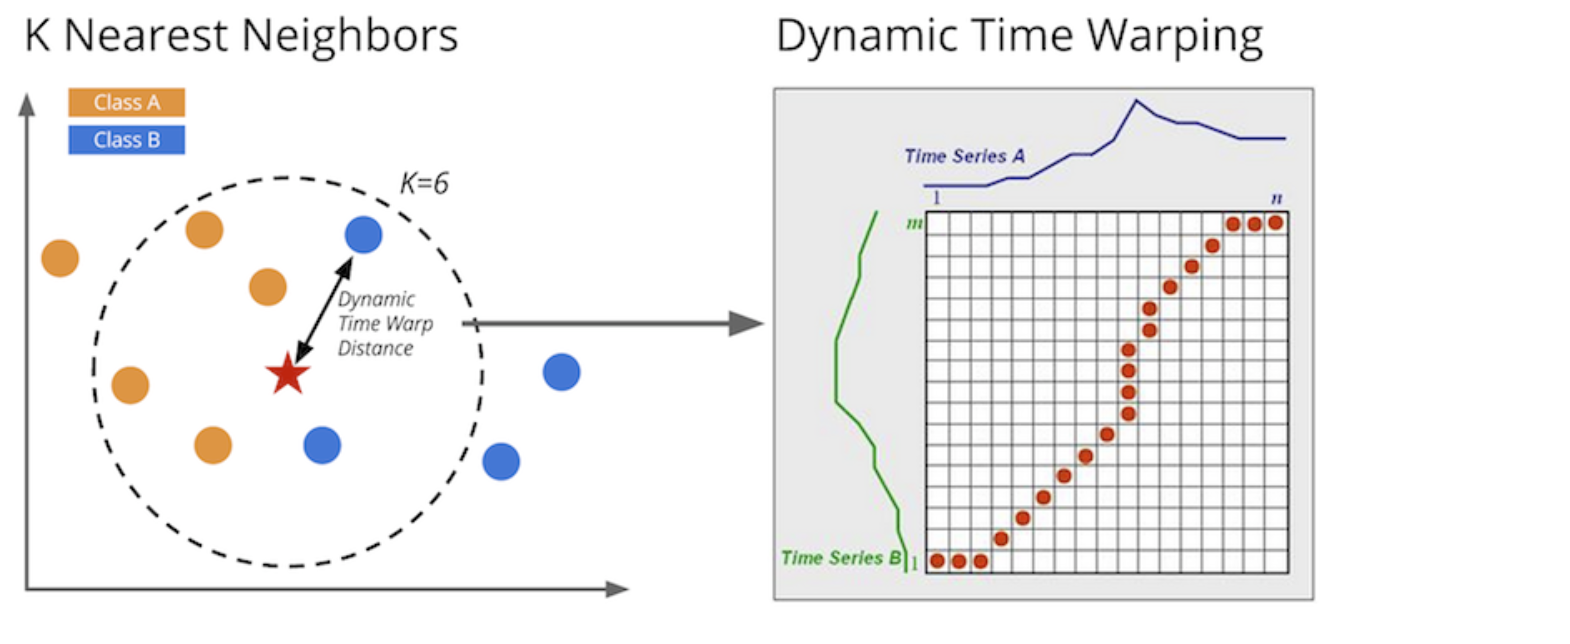

The Dynamic Time Warping (DTW) is a technique that finds an optimal alignment between two sequences. It allows a non-linear mapping of a signal to another by minimizing the distance between the two.
DTW is good for classifying sequences that have different frequences or that are out of phase. 


In [22]:
# We using dtwalign module for fust Dynamic Time Warping computing
from dtwalign import dtw

### Types of windows
There are two main types of windows in DTW algorithm:
 - Sakoechiba
 - Itakura

648.4438561429786


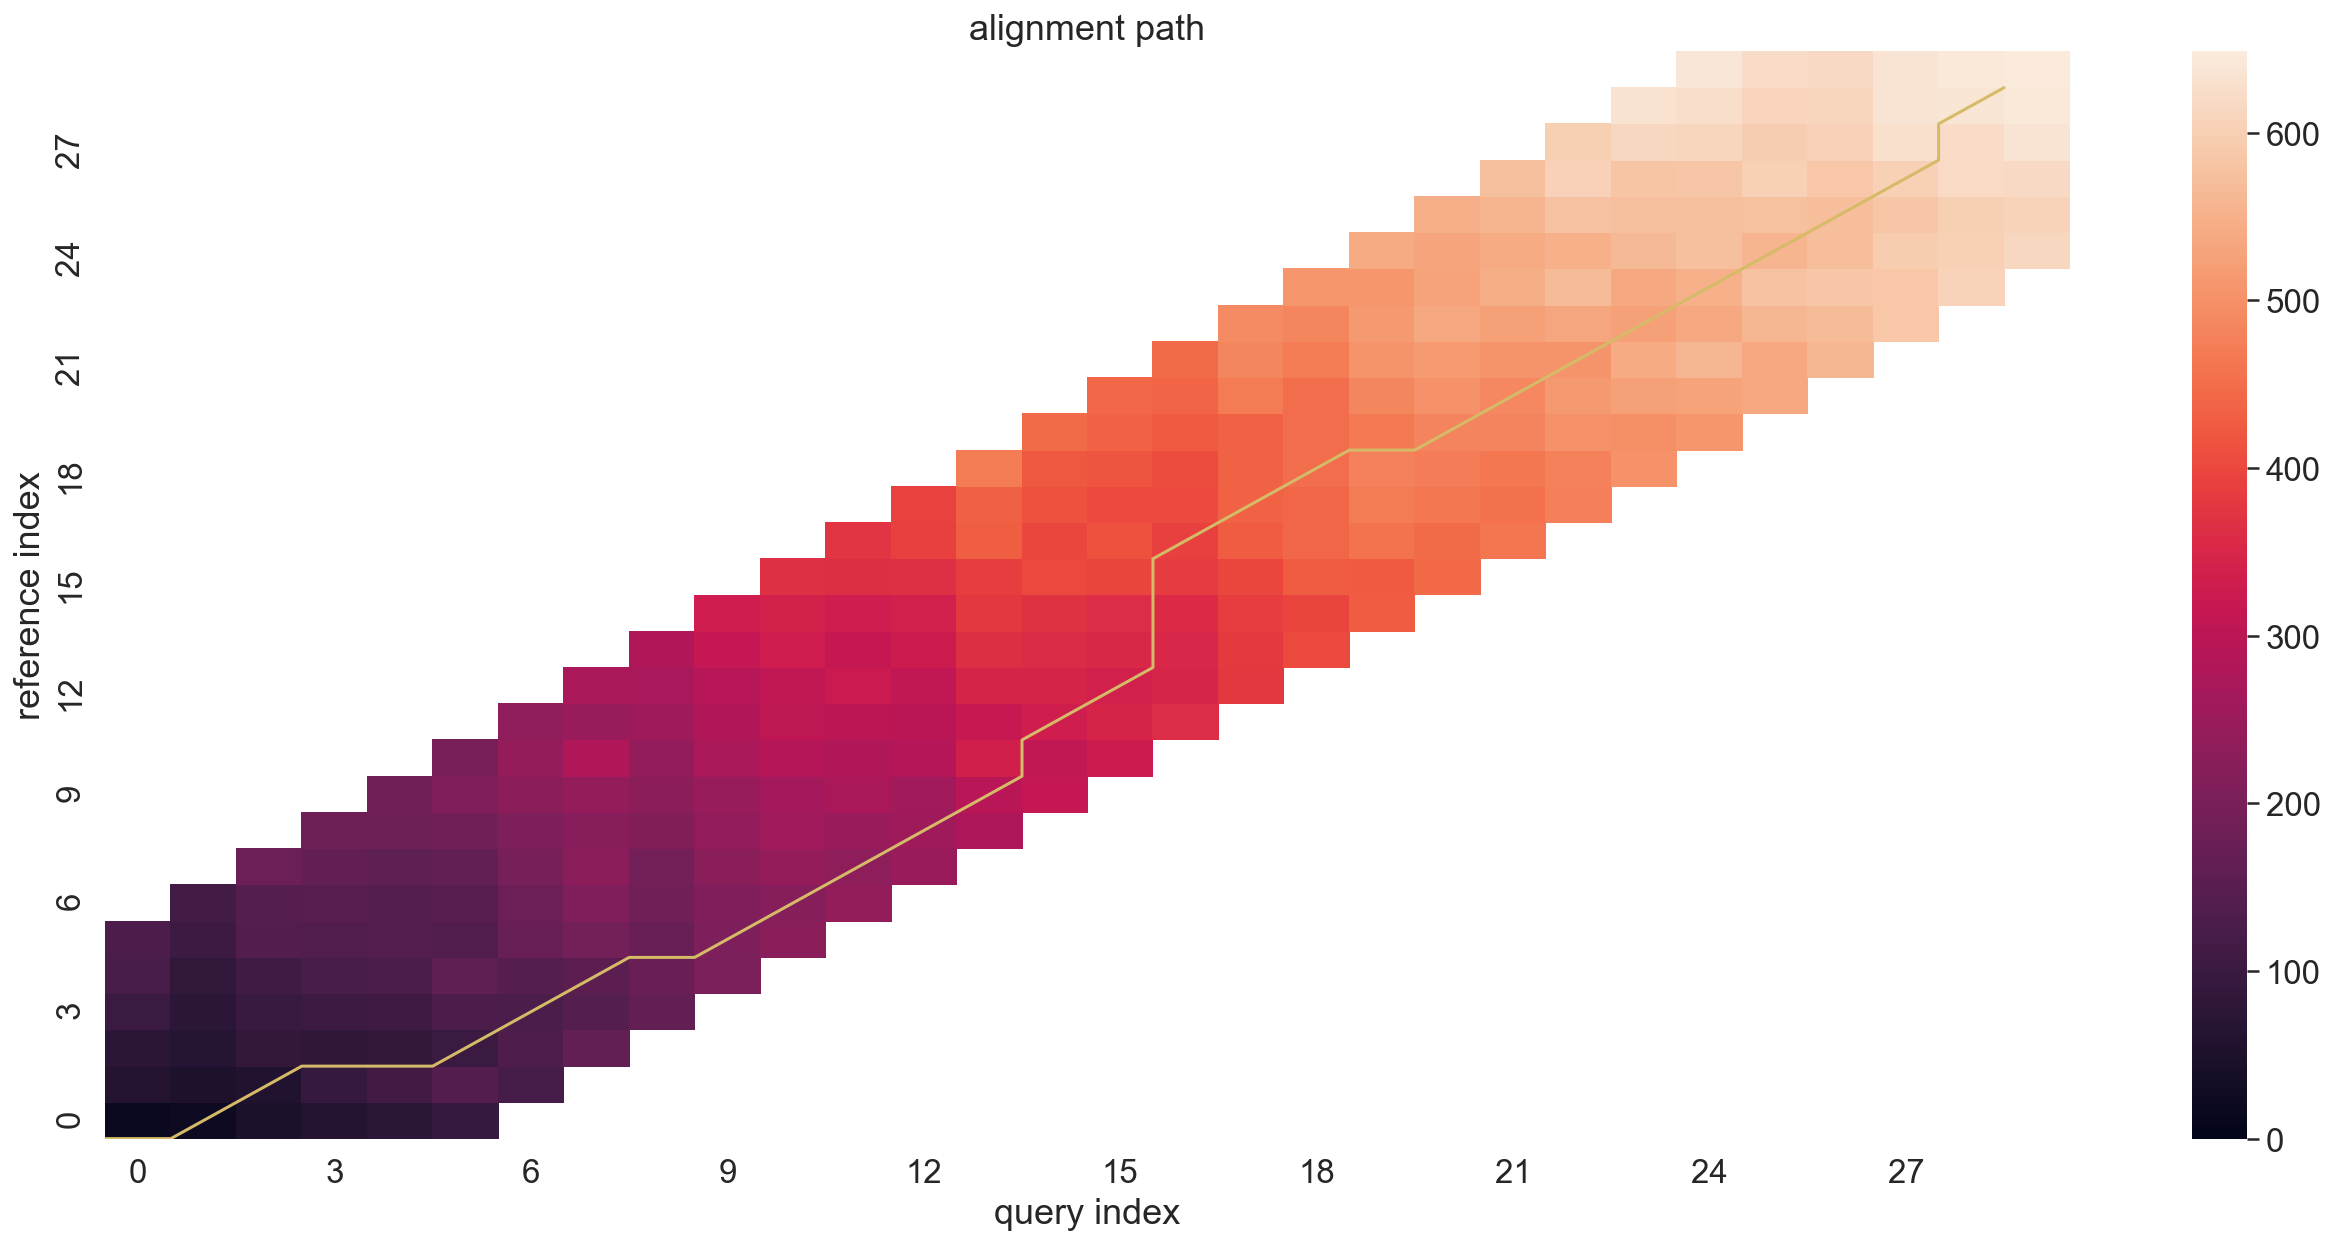

CPU times: user 438 ms, sys: 22.2 ms, total: 460 ms
Wall time: 455 ms


In [25]:
%%time
# run DTW with sakoechiba constraint
res = dtw(X[0], X[1], window_type="sakoechiba", window_size=5)
print(res.distance)
res.plot_path()

651.5645657344688


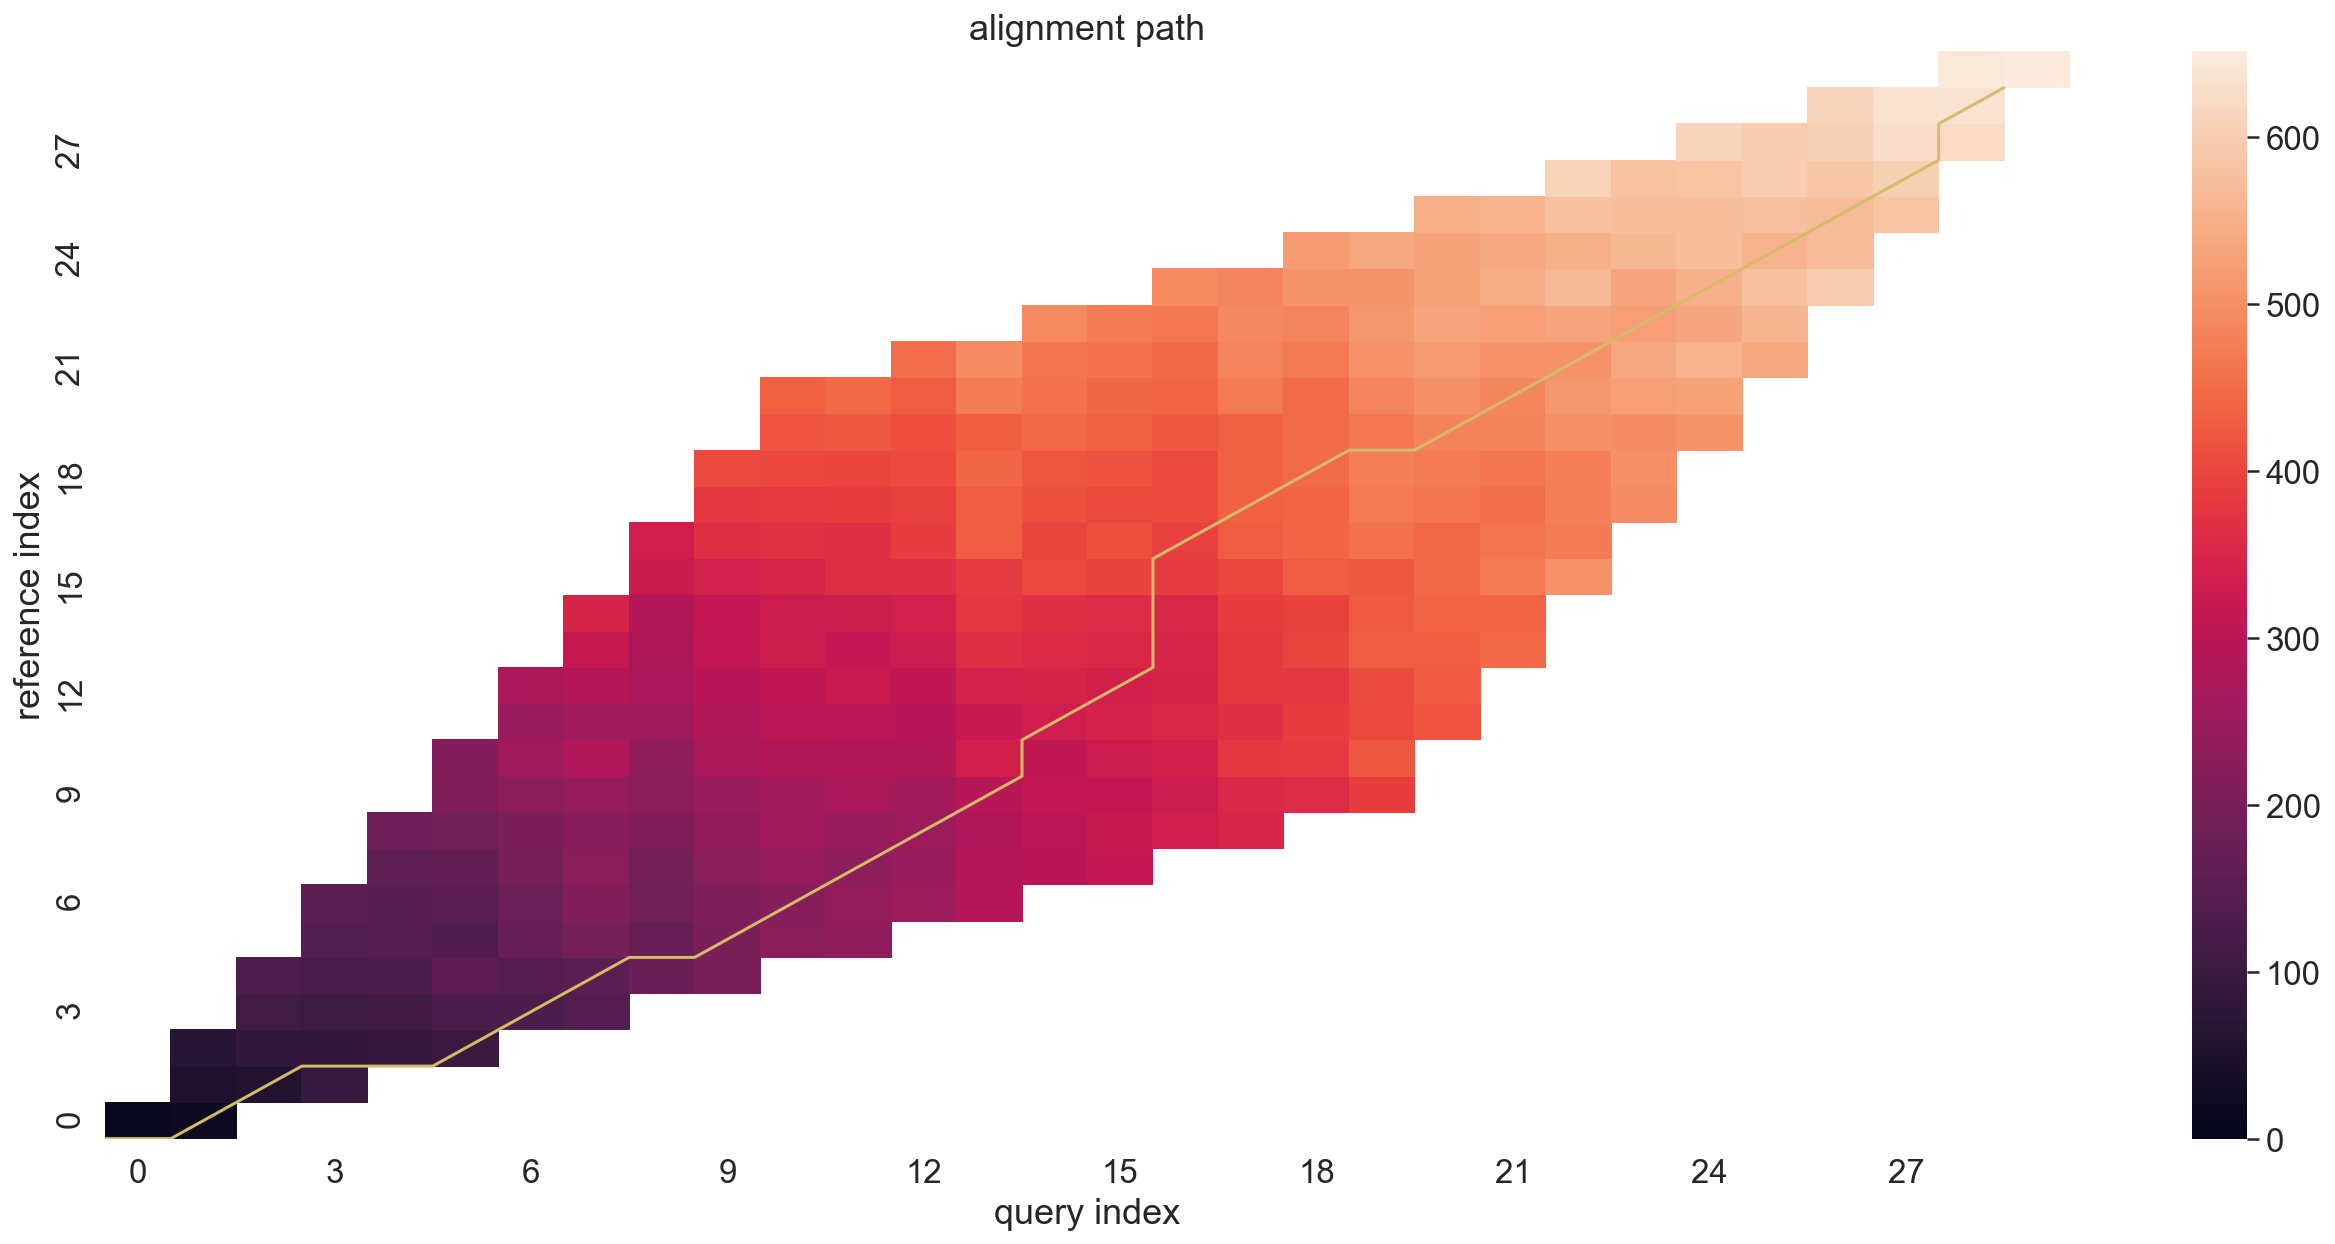

CPU times: user 573 ms, sys: 20.1 ms, total: 593 ms
Wall time: 592 ms


In [26]:
%%time
# run DTW with Itakura constraint
res = dtw(X[0], X[1], window_type="itakura")
print(res.distance)
res.plot_path()

#### We will use sakoechiba window type with window_size=5

In [27]:
import sys
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.spatial.distance import squareform

### Train KnnDtw 

In [28]:
class KnnDtw(object):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays
    
    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for KNN
        
    max_warping_window : int, optional (default = infinity)
        Maximum warping window allowed by the DTW dynamic
        programming function
            
    subsample_step : int, optional (default = 1)
        Step size for the timeseries array. By setting subsample_step = 2,
        the timeseries length will be reduced by 50% because every second
        item is skipped. Implemented by x[:, ::subsample_step]
    """
    
    def __init__(self, n_neighbors=5, max_warping_window=30, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    
    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
            Training data set for input into KNN classifer
            
        l : array of shape [n_samples]
            Training labels for input into KNN classifier
        """
        
        self.x = x
        self.l = l
    
    def _compute_dist(self, a, b):
        res = dtw(a, b, window_type="sakoechiba", window_size=self.max_warping_window)
        return res.distance

    
    def _compute_dist_matrix(self, a, b):
        n = a.shape[0]
        k = b.shape[0]
        scores = []
        for i in range(n):
            sc = []
            for j in range(k):
                sc.append(self._compute_dist(a[i], b[j]))
            scores.append(sc)
            
        return np.array(scores)
        
        
    def predict(self, x):
        """Predict the class labels or probability estimates for 
        the provided data

        Arguments
        ---------
          x : array of shape [n_samples, n_timepoints]
              Array containing the testing data set to be classified
          
        Returns
        -------
          2 arrays representing:
              (1) the predicted class labels 
              (2) the knn label count probability
        """
        
        dm = self._compute_dist_matrix(x, self.x)

        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]
        
        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1]/self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()
    


In [29]:
%%time
m = KnnDtw(max_warping_window=5)
m.fit(X_train, y_train)
m.predict(X[:1])

CPU times: user 706 ms, sys: 2.3 ms, total: 709 ms
Wall time: 708 ms


(array(['running'], dtype='<U7'), array([1.]))

In [31]:
%%time

m = KnnDtw(max_warping_window=5)
m.fit(X_train, y_train)


CPU times: user 47 µs, sys: 1 µs, total: 48 µs
Wall time: 52 µs


Algorithm complexity is 
O(n_t · m_{train} · m_{test}), so it takes some times

In [32]:
%%time
y_knndtw_pred = m.predict(X_test)

CPU times: user 8min 43s, sys: 3.46 s, total: 8min 46s
Wall time: 8min 51s


In [35]:
# y_knndtw_pred

# Compare the results

In [36]:
from sklearn.metrics import classification_report

def plot_cm(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6, 6)) 
    ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=4),
      ax=ax
    )
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()

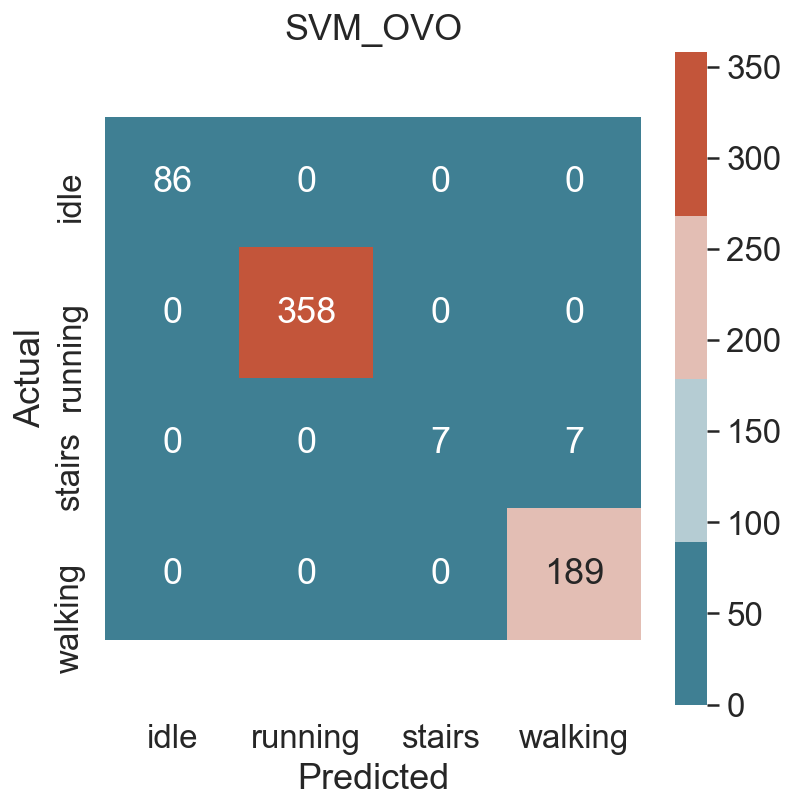

              precision    recall  f1-score   support

        idle       1.00      1.00      1.00        86
     running       1.00      1.00      1.00       358
      stairs       1.00      0.50      0.67        14
     walking       0.96      1.00      0.98       189

    accuracy                           0.99       647
   macro avg       0.99      0.88      0.91       647
weighted avg       0.99      0.99      0.99       647





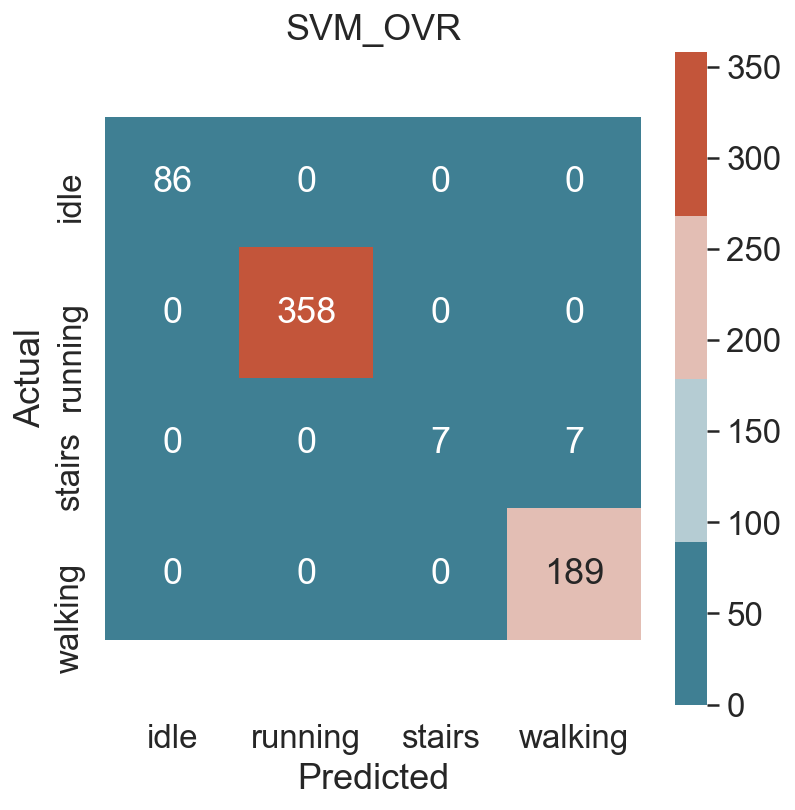

              precision    recall  f1-score   support

        idle       1.00      1.00      1.00        86
     running       1.00      1.00      1.00       358
      stairs       1.00      0.50      0.67        14
     walking       0.96      1.00      0.98       189

    accuracy                           0.99       647
   macro avg       0.99      0.88      0.91       647
weighted avg       0.99      0.99      0.99       647





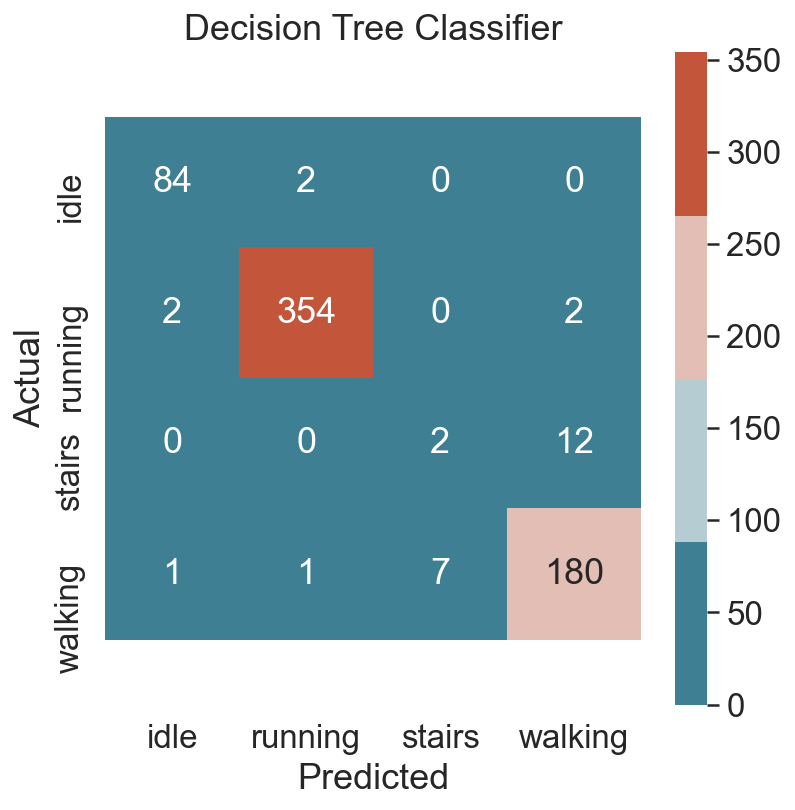

              precision    recall  f1-score   support

        idle       0.97      0.98      0.97        86
     running       0.99      0.99      0.99       358
      stairs       0.22      0.14      0.17        14
     walking       0.93      0.95      0.94       189

    accuracy                           0.96       647
   macro avg       0.78      0.77      0.77       647
weighted avg       0.95      0.96      0.96       647





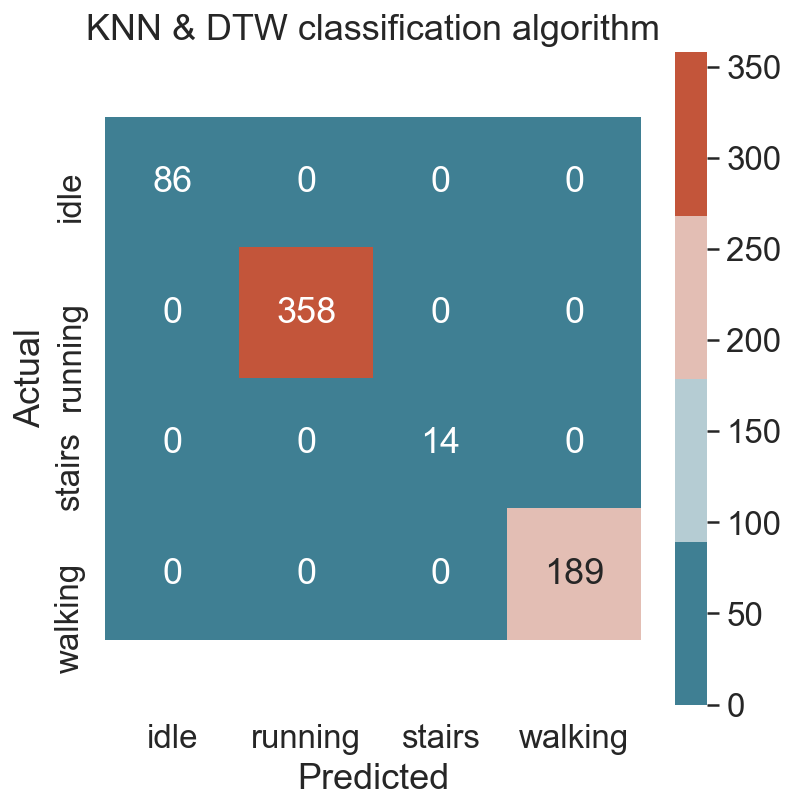

              precision    recall  f1-score   support

        idle       1.00      1.00      1.00        86
     running       1.00      1.00      1.00       358
      stairs       1.00      1.00      1.00        14
     walking       1.00      1.00      1.00       189

    accuracy                           1.00       647
   macro avg       1.00      1.00      1.00       647
weighted avg       1.00      1.00      1.00       647





In [37]:
clf_name = 'SVM_OVO'

plot_cm(
  y_test,
  y_SVM_OVO_pred,
  clf.classes_,
  clf_name
)
print(classification_report(y_test, y_SVM_OVO_pred, target_names=clf.classes_))
print()
print()

clf_name = 'SVM_OVR'

plot_cm(
  y_test,
  y_SVM_OVR_pred,
  clf.classes_,
  clf_name
)
print(classification_report(y_test, y_SVM_OVR_pred, target_names=clf.classes_))
print()
print()

clf_name = 'Decision Tree Classifier'
plot_cm(
  y_test,
  y_DTC_pred,
  clf.classes_, clf_name
)
print(classification_report(y_test, y_DTC_pred, target_names=clf.classes_))
print()
print()


clf_name = 'KNN & DTW classification algorithm'
plot_cm(
  y_test,
  y_knndtw_pred[0],
  clf.classes_, clf_name
)
print(classification_report(y_test, y_knndtw_pred[0], target_names=clf.classes_))


print()
print()

KNN_DTW provides best results (with a f1-score = 1). This is due to the fact that every movement considered significantly differs from the other, so helping the algorithm having a better match between the accelerometer sequences. However, the algorithm takes more time to predict than the others. 

Finally, Decision Tree Classifier shows the worst result (f1-score = 0.96).

We also can notice that SVM and Decision Tree Classifier algorithms often confuse classes "stairs" and "walking" and easily identify classes "idle" and "running". Thats because classes "stairs" and "walking" is not linearly separable.